In [14]:
import os
import cv2
import numpy as np 
import pandas as pd 
import xml.etree.ElementTree as ET

from sklearn import preprocessing
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception

In [15]:
directory_annotations  = "annotations/"
label_annottion = os.listdir(directory_annotations)
files = []
for lbl in label_annottion:
    files.append(lbl.split('.')[0])
fcount = len(files)
indexes = []
for index in range(fcount):
     indexes.append(index)
train_data = indexes[:int(fcount*0.7)]
validation_data = indexes[int(fcount*0.9):]

In [16]:
dir_images = 'path/'
dir_annotations = 'annotations/'
label_names = preprocessing.LabelEncoder()
label_names.fit(['acariens', 'chancre fusicocum','othyorinques', 'coryneum', 'faux tigre',
       'polystigma', 'rouille', 'scolytes'])

LabelEncoder()

In [50]:


def generate_xml(file):
    labels = np.zeros((8), dtype = 'float32')
    tree = ET.parse(os.path.join(dir_annotations, file+ ".xml"))
    raw_image = cv2.imread(os.path.join(dir_images, file+ ".jpeg" ))
    res_img = cv2.resize(raw_image, (320,240))
    for elems in tree.iter():
        if elems.tag == "object":
            name = elems.find("name").text
            labelnr = label_names.transform([name])[0]
            labels[labelnr] = 1
      
    return labels, res_img



In [51]:
raw_image = cv2.imread(os.path.join(dir_images,'new_data0'+ ".jpeg" ))

In [52]:
res_img = cv2.resize(raw_image, (320,240))

In [71]:
generate_xml('new_data0')[1][4]

array([[104, 129,  95],
       [105, 132,  99],
       [102, 133, 100],
       [ 81, 115,  84],
       [ 74, 110,  80],
       [ 65, 106,  75],
       [ 76, 116,  88],
       [ 96, 138, 111],
       [ 80, 123,  96],
       [ 51,  96,  70],
       [ 58, 104,  78],
       [ 46,  95,  67],
       [ 29,  80,  48],
       [ 38,  86,  58],
       [ 72, 109,  96],
       [109, 137, 137],
       [ 83,  97,  95],
       [ 57,  76,  82],
       [ 75, 100, 117],
       [101, 128, 154],
       [120, 147, 176],
       [105, 132, 157],
       [ 86, 112, 133],
       [ 89, 115, 131],
       [ 76,  99, 112],
       [ 62,  84,  90],
       [ 78,  98, 103],
       [ 58,  73,  76],
       [ 64,  78,  80],
       [ 60,  72,  72],
       [ 61,  74,  72],
       [ 72,  84,  81],
       [ 82,  96,  90],
       [ 93, 106, 103],
       [ 94, 107, 106],
       [ 88, 100, 102],
       [ 94, 104, 110],
       [121, 141, 139],
       [136, 162, 152],
       [132, 161, 144],
       [107, 142, 115],
       [ 96, 136

In [72]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, list_IDs, datafiles, batch_size = 16, n_classes = 8, shuffle = True):
        self.batch_size = batch_size
        self.datafiles = datafiles
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, 240, 320, 3))
        y = np.empty((self.batch_size, 8))

        for datactr in range (self.batch_size):
            newlabel, newimg = generate_xml(self.datafiles[list_IDs_temp[datactr]])
            y[datactr] = newlabel
            X[datactr] = newimg

        return X, y

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        newindexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in newindexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [73]:
training_generator = DataGenerator(train_data, files)
val_generator = DataGenerator(validation_data, files)

In [64]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('xceptions')

In [74]:
x = Dense_net.get_layer("global_average_pooling2d_3").output

#x = tf.keras.layers.Dense(1024, activation='softmax')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [75]:
history = model.fit_generator(generator=training_generator,
            validation_data=val_generator,
            epochs = 80)

Epoch 1/80
26/26 [==============================] - 20s 612ms/step - loss: 1.0545 - accuracy: 0.6034 - val_loss: 2.6520 - val_accuracy: 0.3542
Epoch 2/80
26/26 [==============================] - 16s 579ms/step - loss: 0.6275 - accuracy: 0.7716 - val_loss: 2.4220 - val_accuracy: 0.3125
Epoch 3/80
26/26 [==============================] - 15s 575ms/step - loss: 0.5509 - accuracy: 0.7981 - val_loss: 1.8246 - val_accuracy: 0.5000
Epoch 4/80
26/26 [==============================] - 16s 580ms/step - loss: 0.4847 - accuracy: 0.8221 - val_loss: 1.8219 - val_accuracy: 0.3750
Epoch 5/80
26/26 [==============================] - 16s 578ms/step - loss: 0.4072 - accuracy: 0.8942 - val_loss: 2.5363 - val_accuracy: 0.2500
Epoch 6/80
26/26 [==============================] - 15s 577ms/step - loss: 0.3309 - accuracy: 0.9038 - val_loss: 2.9994 - val_accuracy: 0.3333
Epoch 7/80
26/26 [==============================] - 16s 579ms/step - loss: 0.3122 - accuracy: 0.8966 - val_loss: 4.5919 - val_accuracy: 0.3333

In [76]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

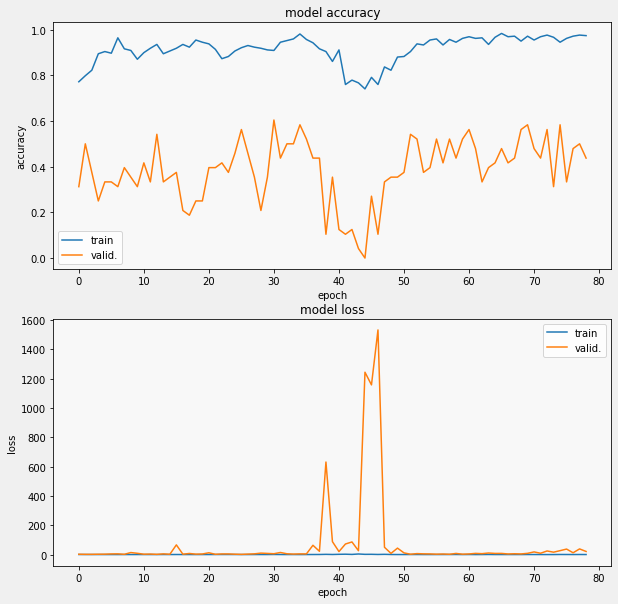

In [77]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [78]:
import pickle
with open('training_log/segmentation_transfert_80.pkl', 'wb') as output:
        pickle.dump(history.history, output)